In [25]:
import pandas as pd
import lightgbm as lgb
import seaborn as sns
from tqdm.auto import tqdm
from sklift import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.base import clone

from collections import defaultdict

In [3]:
data_path = "../../data/preprocessed/"  # features_with_target.csv

transaction_features = pd.read_csv(data_path + "x5_transaction_features.csv", index_col="client_id")
client_features = pd.read_csv(data_path + "x5_client_features.csv", index_col="client_id")
df_target = pd.read_csv("../../data/datasets/x5-retail-hero/uplift_train.csv.gz", index_col="client_id")
df = transaction_features.join(client_features).join(df_target)
df = df[df.age > 0]
df = df[df.age < 110]
df

,regular_points_received_mean,regular_points_received_std,regular_points_received_median,regular_points_received_max,regular_points_received_skew,express_points_received_mean,express_points_received_std,express_points_received_median,express_points_received_max,express_points_received_skew,...,percent_of_transactions_in_12_month,age,first_issue_time,first_redeem_time,issue_redeem_delay,F,M,U,treatment_flg,target
client_id,,,,,,,,,,,,,,,,,,,,,
000012768d,6.425000,2.973529,6.85,10.0,-0.355890,0.000,0.000000,0.0,0.0,0.000000,...,2,45,0.336675,0.735365,0.398690,0,0,1,0,1
000036f903,1.715625,1.461401,1.30,7.0,2.367965,1.875,10.439558,0.0,60.0,5.388159,...,10,72,0.015925,0.033211,0.017286,1,0,0,1,1
00010925a5,1.766667,1.139688,1.45,5.8,2.321282,0.000,0.000000,0.0,0.0,0.000000,...,6,83,1.303876,1.428140,0.124264,0,0,1,1,1
0001f552b0,5.260000,9.686334,1.60,39.7,2.953750,0.000,0.000000,0.0,0.0,0.000000,...,4,33,0.238463,1.381198,1.142734,1,0,0,1,1
00020e7b18,15.894444,13.081389,14.60,44.5,0.819229,0.000,0.000000,0.0,0.0,0.000000,...,2,73,0.648549,0.751613,0.103064,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffe0abb97,2.466667,3.003701,0.70,7.3,0.703218,0.000,0.000000,0.0,0.0,0.000000,...,1,35,0.648236,0.838325,0.190090,1,0,0,0,0
fffe0ed719,2.330000,2.281542,1.50,8.6,1.531437,0.000,0.000000,0.0,0.0,0.000000,...,4,69,0.448229,0.671819,0.223590,0,0,1,0,1
fffea1204c,1.535294,1.710845,0.90,5.9,1.563107,0.000,0.000000,0.0,0.0,0.000000,...,4,73,0.827236,0.918646,0.091409,1,0,0,0,1


In [4]:
def split_df(df, columns = None):
    features = df[df.columns.difference(['treatment_flg', 'target', 'client_id', 'gender'])]
    if columns is not None:
        features = features[columns]
    y_target = df.target
    treatment = df.treatment_flg
    
    return features, y_target, treatment

In [5]:
df_train, df_test = train_test_split(df, train_size=0.8, stratify=df.treatment_flg, random_state=42)

# Models

In [9]:
from causalml.inference.meta import (
    LRSRegressor, 
    XGBTRegressor, 
    MLPTRegressor, 
    BaseXRegressor, 
    BaseRRegressor
)

In [31]:
def cross_validate(model, df: pd.DataFrame, kfold_params: dict, metrics_dict: dict):
    results = defaultdict(list)
    
    for train_index, test_index in tqdm(KFold(**kfold_params).split(df)):
        train_df, test_df = df.iloc[train_index], df.iloc[test_index]
        x_train, y_train, t_train = split_df(train_df)
        x_test, y_test, t_test = split_df(test_df)
        
        model.fit(x_train, t_train, y_train)
        prediction = model.predict(x_test)[:, 0]
        for metric_name, metric_fn in metrics_dict.items():
            results[metric_name].append(metric_fn(prediction, y_test, t_test))
            
    return results


metrics_dict = {
    'uplift@30': lambda p, y, t: metrics.uplift_at_k(y, p, t, strategy="by_group", k=0.3),
    'auuc': lambda p, y, t: metrics.uplift_auc_score(y, p, t)
}

cross_validate(XGBTRegressor(random_state=42), df, {'n_splits': 5}, metrics_dict)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


defaultdict(list,
            {'uplift@30': [0.05276664882962023,
              0.03795152491912046,
              0.06760275120686576,
              0.061299095322538855,
              0.055678771393573356],
             'auuc': [0.013620858579772249,
              0.0056699477959739454,
              0.013346067555209633,
              0.017471882241161897,
              0.014931994494276036]})

In [11]:
x_train, y_train, t_train = split_df(df_train)
model = XGBTRegressor(random_state=42)
model.fit(x_train, t_train, y_train)

In [12]:
x_test, y_test, t_test = split_df(df_test)
predictions = model.predict(x_test)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


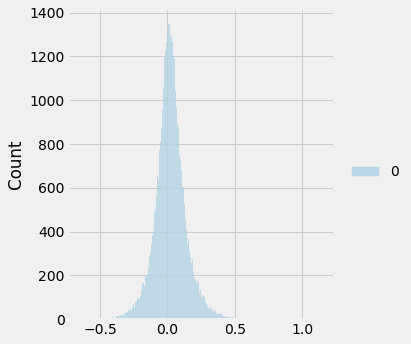

In [13]:
sns.displot(predictions)

# Interpretability

In [40]:
model.fit(x_train, t_train, y_train)

In [66]:
import warnings

import shap
shap.initjs()

# explainer = shap.TreeExplainer(model.models_c[1])
# shap_values = explainer.shap_values(x_test.sample(1000))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    data = x_test.sample(1000)
    explainer = shap.KernelExplainer(lambda x: model.predict(x)[:, 0], data=data)
    shap_values = explainer.shap_values(data)

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


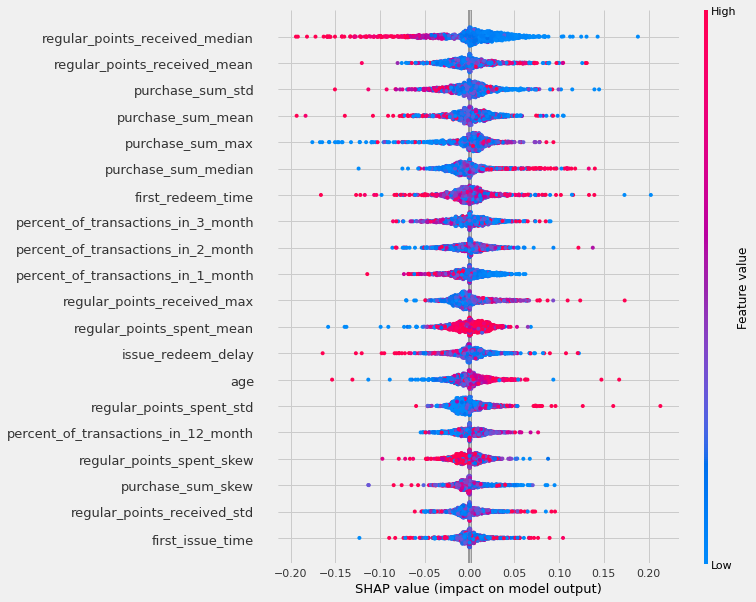

In [69]:
shap.summary_plot(shap_values, data)

# Evaluation

In [19]:
from sklift import metrics

metrics.uplift_at_k(y_test, predictions[:, 0], t_test, strategy="by_group", k=0.3)

0.05588546409215378

In [17]:
predictions

array([[ 0.02826324],
       [ 0.02181262],
       [ 0.04883245],
       ...,
       [-0.01357049],
       [ 0.23709175],
       [-0.13999224]])